<a href="https://colab.research.google.com/github/moh2236945/Natural-language-processing/blob/master/Text_Classification_in_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Networks with convolutional and pooling layers are useful for classification tasks in which we expect to find strong local clues regarding class membership, but these clues can appear in different places in the input. […] We would like to learn that certain sequences of words are good indicators of the topic, and do not necessarily care where they appear in the document. Convolutional and pooling layers allow the model to learn to find such local indicators, regardless of their position

architecture is therefore comprised of three key pieces:

1.   Word Embedding: A distributed representation of words where different words that have a similar meaning (based on their usage) also have a similar representation.

2.   Convolutional Model: A feature extraction model that learns to extract salient features from documents represented using a word embedding.
3. Fully Connected Model: The interpretation of extracted features in terms of a predictive output.




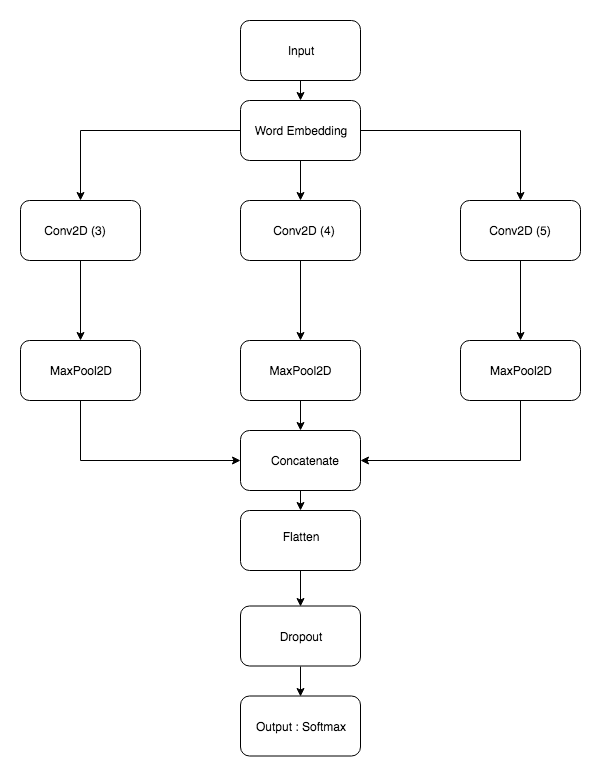

In [0]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation,Conv2D,Flatten,Dropout,Dense,Conv1D
from keras.models import Model
from keras.layers import MaxPool1D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


In [0]:
#Data set path
text_data_dir=
glove_dir=
max_words=1000
max_sequence_length=1000
validation_split=0.20
embeddding_dim=100
filter_size=[3,4,5]
num_filters=512
embedding_dim=100
drop=0.5
batch_size=30
epoch=5


DATASET STRUCTURE

The dataset is present in a hierarchical structure, i.e. all files of a given class are located in their respective folders and each datapoint has its own '.txt' file.

First we go through the entire dataset to build our text list and label list.
Followed by this we tokenize the entire data using Tokenizer, which is a part of keras.preprocessing.text.
We then add padding to the sequences to make them of a uniform length.

In [0]:
#preparing Dataset
texts=[] #text sample
labels_index={}
labels=[]
for name in sorted(os.listdir(text_data_dir)):
    path=os.path.join(text_data_dir,name)
    if os.path.is_dir(path):
        label_id=len(label_index)
        labels_index[name]=label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath=os.path.join(path,fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)
print(labels_index)

print('Found %s texts.' % len(texts))

In [0]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

In [0]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [0]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=20, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))